In [18]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
import re
from exactextract import exact_extract
from tqdm import tqdm
import damagescanner.download as download

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyBboxPatch
from lonboard import viz
from damagescanner.vector import _get_cell_area_m2
from pyproj import Geod
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import pandas as pd
from matplotlib.lines import Line2D
import rioxarray as rxr
import pyproj

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

In [19]:
data_path = Path('input_files')
figure_path = Path('figures')
intermediate_path = Path('intermediate_results')

In [5]:
# Load country outline
world_path = data_path / "ne_10m_admin_0_countries.shp"
world = gpd.read_file(world_path)
country_bounds = world.loc[world.SOV_A3 == 'SRB'].bounds
country_plot = world.loc[world.SOV_A3 == 'SRB']

In [6]:
# read flood data
fluvial_flooding_path = data_path / "Europe_RP100_filled_depth.tif"

In [8]:
hazard_map = xr.open_dataset(fluvial_flooding_path, engine="rasterio")
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                 miny=country_bounds.miny.values[0],
                 maxx=country_bounds.maxx.values[0],
                 maxy=country_bounds.maxy.values[0]
                ).load()

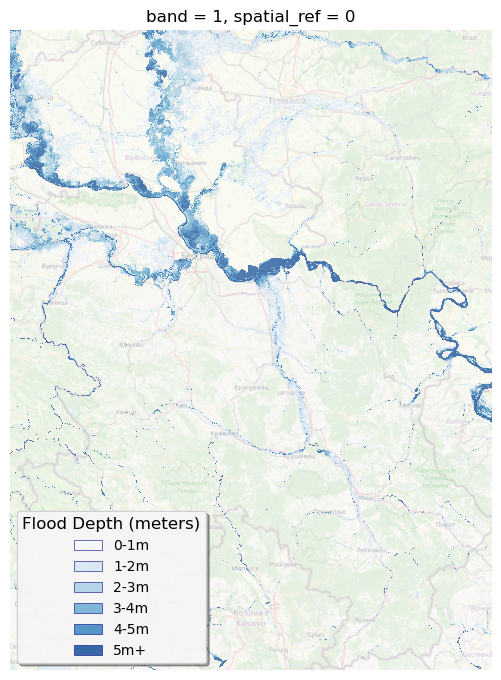

In [20]:
# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Create blue flood risk colormap - light to dark blue
# Light blue (low/no risk) to dark blue (high risk)
flood_colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
flood_cmap = LinearSegmentedColormap.from_list('flood_blue', flood_colors, N=256)

# Plot the flood hazard xarray data


# Check if data needs reprojection (assuming WGS84 lat/lon input)
if hazard_country.rio.crs is None:
    hazard_country = hazard_country.rio.write_crs("EPSG:4326")

# Reproject to Web Mercator for basemap overlay
hazard_mercator = hazard_country.rio.reproject("EPSG:3857")

# Plot the raster data
flood_plot = hazard_mercator.band_data.plot(
    ax=ax,
    cmap=flood_cmap,
    alpha=0.7,  # Semi-transparent so basemap shows through
    vmin=0,
    vmax=6,     # Updated for 5+ meter depths
    add_colorbar=False  # We'll create a custom legend and colorbar
)

# Add basemap with optimal styling for PNG
cx.add_basemap(
    ax=ax, 
    source=cx.providers.OpenStreetMap.Mapnik,
    alpha=0.4,
    attribution=False
)

# Enhance the plot styling
ax.axis('off')  # Remove axis for cleaner look

# Create flood risk categories for legend - in 1-meter increments
flood_bins = [0, 1, 2, 3, 4, 5, np.inf]
flood_labels = ['0-1m', '1-2m', '2-3m', '3-4m', '4-5m', '5m+']

# Get colors for legend from the blue colormap
legend_colors = [flood_cmap(i/5) for i in range(6)]  # 6 categories now

# Create custom legend in upper right corner
legend_elements = [Patch(facecolor=legend_colors[i], 
                        label=flood_labels[i], 
                        edgecolor='navy', 
                        linewidth=0.5, 
                        alpha=0.8) 
                  for i in range(len(flood_labels))]

legend = ax.legend(handles=legend_elements, 
                  title='Flood Depth (meters)', 
                  loc='lower left',
                  fontsize=10,
                  title_fontsize=12,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

# Add subtitle with flood data info
flood_data = hazard_country.band_data.values.flatten()
flood_data_clean = flood_data[~np.isnan(flood_data)]

fig.suptitle("")

# Enhance overall plot appearance
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.88)  # Make room for colorbar
plt.savefig(figure_path / 'flood_depth_map.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
snow_drift = gpd.read_file(data_path / "snezni_nanosi_studije.shp")

C:\Users\eks510\.conda\envs\pygis\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


<module 'matplotlib.pyplot' from 'C:\\Users\\eks510\\.conda\\envs\\pygis\\Lib\\site-packages\\matplotlib\\pyplot.py'>

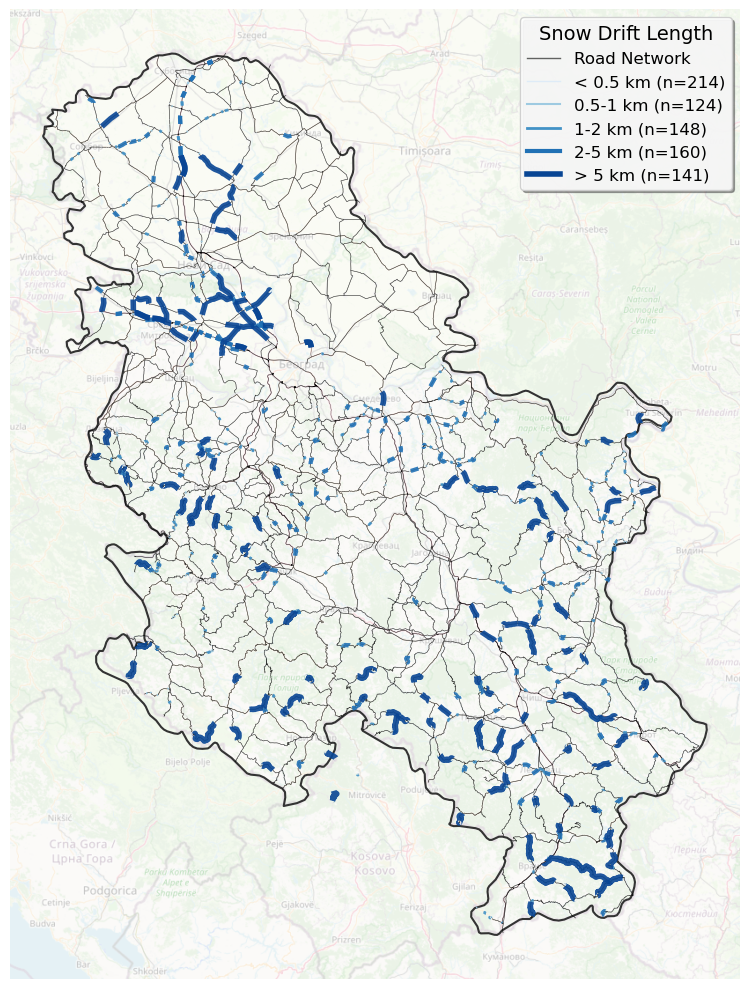

In [20]:
# Load baseline road network
baseline_roads = gpd.read_parquet(intermediate_path / "PERS_directed_final.parquet")

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')

# Convert to Web Mercator for basemap
serbia_mercator = country_plot.to_crs(3857)
baseline_mercator = baseline_roads.to_crs(3857)
snow_drift_mercator = snow_drift.to_crs(3857)

# Define length bins and labels (in km)
bins = [0, 0.5, 1, 2, 5, float('inf')]
labels = ['< 0.5 km', '0.5-1 km', '1-2 km', '2-5 km', '> 5 km']
snow_drift_mercator['length_class'] = pd.cut(
    snow_drift_mercator['dužina_sn'], 
    bins=bins, labels=labels, include_lowest=True
)

# Define colors and linewidths - longer = thicker/darker
colors = {
    '< 0.5 km': '#deebf7',
    '0.5-1 km': '#9ecae1', 
    '1-2 km': '#4292c6',
    '2-5 km': '#2171b5',
    '> 5 km': '#084594'
}

linewidths = {
    '< 0.5 km': 1.0,
    '0.5-1 km': 1.5, 
    '1-2 km': 2.0,
    '2-5 km': 3.0,
    '> 5 km': 4.0
}

# Plot country outline first
serbia_mercator.plot(ax=ax, facecolor='none', edgecolor='#333333', 
                     linewidth=1.5, zorder=2)

# Plot baseline road network in grey
baseline_mercator.plot(ax=ax, color='black', linewidth=0.4, 
                       alpha=0.5, zorder=2)

# Plot snow drifts by length class on top
for length_class in labels:
    subset = snow_drift_mercator[snow_drift_mercator['length_class'] == length_class]
    if len(subset) > 0:
        subset.plot(ax=ax, color=colors[length_class], 
                    linewidth=linewidths[length_class], 
                    alpha=0.9, zorder=3)

# Add basemap
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, 
               alpha=0.3, attribution=False)

ax.set_aspect('equal')
ax.axis('off')

# Create legend
legend_elements = [
    Line2D([0], [0], color='black', linewidth=1, label='Road Network', alpha=0.6)
] + [
    Line2D([0], [0], color=colors[label], linewidth=linewidths[label],
           label=f'{label} (n={len(snow_drift_mercator[snow_drift_mercator["length_class"] == label])})')
    for label in labels
]
ax.legend(handles=legend_elements, title='Snow Drift Length', loc='upper right', 
          fontsize=12, title_fontsize=14,
          frameon=True, fancybox=True, shadow=True,
          framealpha=0.9, facecolor='white', edgecolor='#cccccc')

plt.tight_layout()
plt.savefig(figure_path / 'snow_drift_map.png', dpi=300, bbox_inches='tight')
plt

In [21]:
landslides = gpd.read_file(data_path / "Nestabilne_pojave.shp")

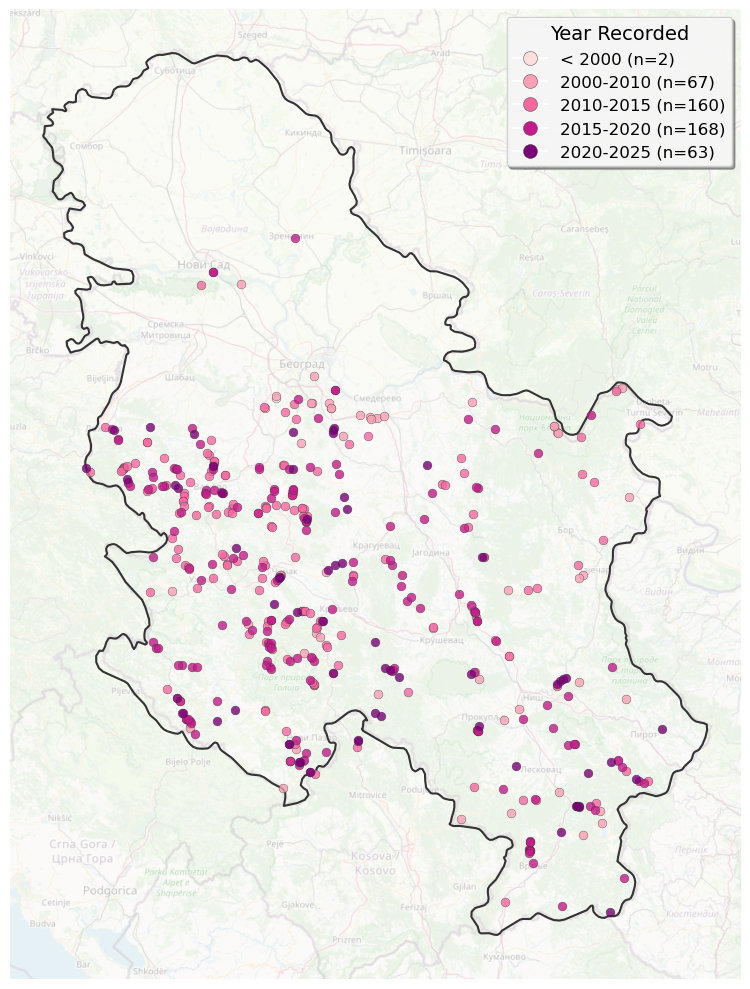

In [22]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')

# Convert to Web Mercator for basemap
serbia_mercator = country_plot.to_crs(3857)
landslides_mercator = landslides.to_crs(3857)

# Extract year from datum_evid
landslides_mercator['year'] = pd.to_datetime(landslides_mercator['datum_evid']).dt.year

# Define year bins and labels
bins = [0, 2000, 2010, 2015, 2020, 2030]
labels = ['< 2000', '2000-2010', '2010-2015', '2015-2020', '2020-2025']
landslides_mercator['year_class'] = pd.cut(
    landslides_mercator['year'], 
    bins=bins, labels=labels, include_lowest=True
)

# Define colors - sequential from light to dark (older to newer)
colors = {
    '< 2000': '#fde0dd',
    '2000-2010': '#fa9fb5', 
    '2010-2015': '#f768a1',
    '2015-2020': '#c51b8a',
    '2020-2025': '#7a0177'
}

# Plot country outline first (as background)
serbia_mercator.plot(ax=ax, facecolor='none', edgecolor='#333333', 
                     linewidth=1.5, zorder=2)

# Plot landslides by year class
for year_class in labels:
    subset = landslides_mercator[landslides_mercator['year_class'] == year_class]
    if len(subset) > 0:
        subset.plot(ax=ax, color=colors[year_class], markersize=40, 
                    alpha=0.8, edgecolor='#333333', 
                    linewidth=0.3, zorder=3)

# Add basemap
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, 
               alpha=0.3, attribution=False)

ax.set_aspect('equal')
ax.axis('off')

# Create legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=colors[label], markersize=10,
           markeredgecolor='#333333', markeredgewidth=0.3,
           label=f'{label} (n={len(landslides_mercator[landslides_mercator["year_class"] == label])})')
    for label in labels
]
ax.legend(handles=legend_elements, title='Year Recorded', loc='upper right', 
          fontsize=12, title_fontsize=14,
          frameon=True, fancybox=True, shadow=True,
          framealpha=0.9, facecolor='white', edgecolor='#cccccc')

plt.tight_layout()
plt.savefig(figure_path / 'landslides_map_by_year.png', dpi=300, bbox_inches='tight')
plt.show()